Standard Jupyter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

Install via pip

In [2]:
from pykalman import KalmanFilter

Setup Stock prices

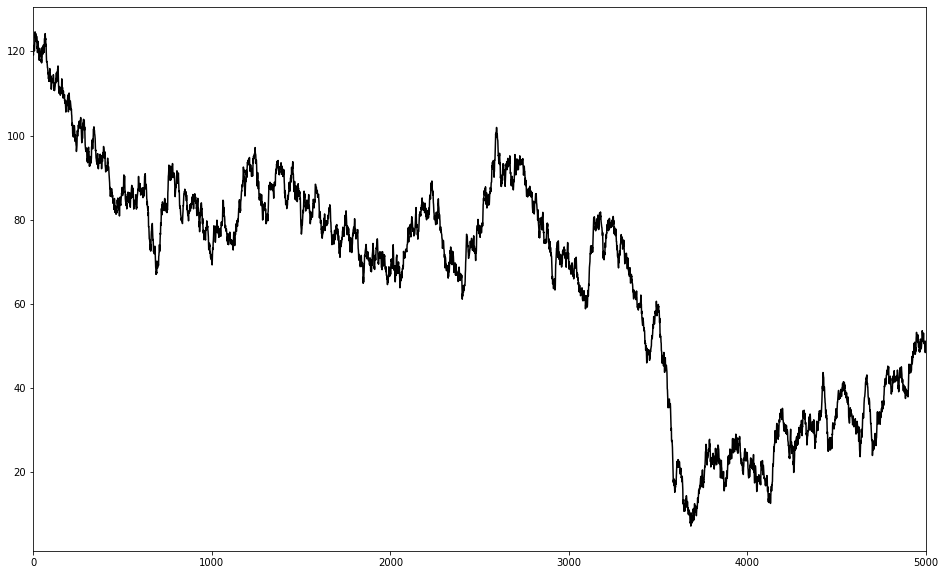

In [3]:
np.random.seed(500)

N = 5000
S0 = 120

S = S0 + np.random.normal(0, 1, N).cumsum()
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
ax.plot(S, c='black')
ax.set_xlim(0, N)

plt.show()

Moving averages to smooth the data.

In [4]:
def mean_and_std(seq):
    return [seq.mean(), seq.std()]

def moving_average(a, n):
    i = 15
    return np.array([ 
        mean_and_std(a[max(0, i-n):i+1])
        for i, _ in enumerate(a) 
    ])

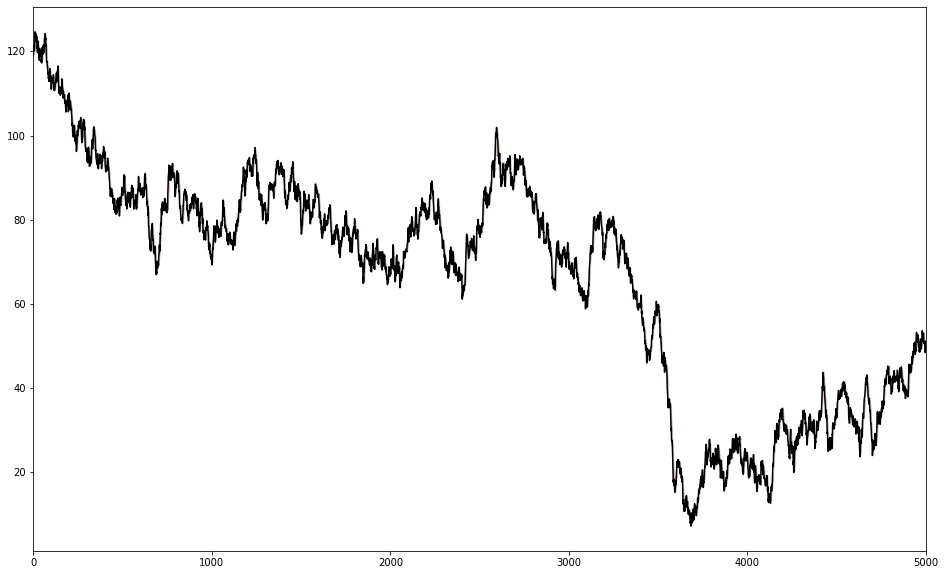

In [5]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)

t = np.arange(len(S))

avg = moving_average(S, 5)
ax.plot(t, avg[:,0], c='red')
ax.plot(t, avg[:,0] + avg[:,1], c='lightgray')
ax.plot(t, avg[:,0] - avg[:,1], c='lightgray')

ax.plot(t, S, c='black')

ax.set_xlim(0, N)

plt.show()

Work with the smoothed data instead.

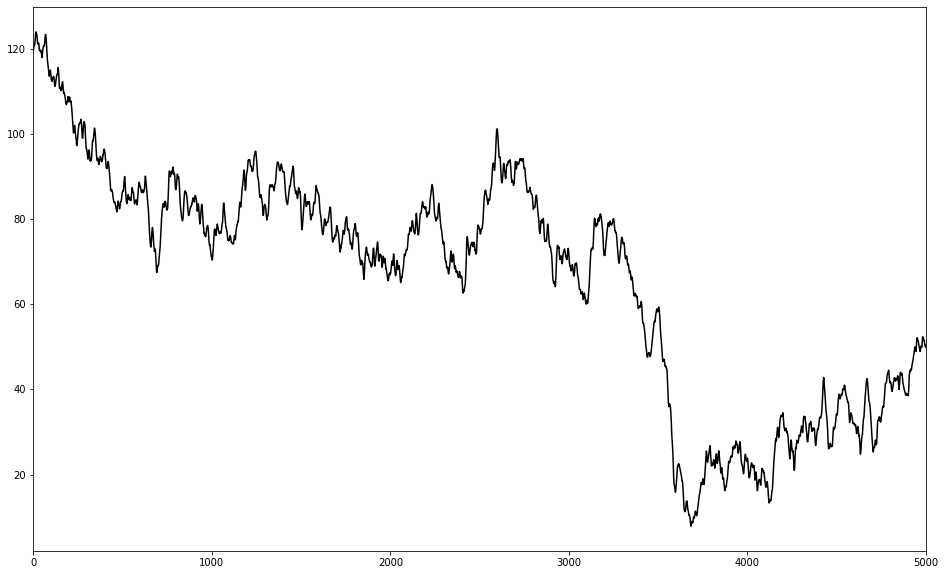

In [6]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)

t = np.arange(len(S))

avg = moving_average(S, 5)
ax.plot(t, avg[:,0], c='black')

ax.set_xlim(0, N)

plt.show()

Fitting a polynomial to the data.

In [7]:
def poly_fit(fit_start, t, S, data_len, fit_len):
    t_ = t[fit_start-data_len:fit_start]
    y  = S[fit_start-data_len:fit_start]
    print(len(y), len(t_))

    # p is used to plot the polynomials.
    p = np.linspace(fit_start-data_len, fit_start+fit_len, data_len+fit_len)

    vander_ = np.vander(t_, 5)
    lst_sq = np.linalg.lstsq(vander_, y, rcond=None)[0]
    p4, p3, p2, p1, p0 = lst_sq
    
    return p, p4*p**4 + p3*p**3 + p2*p**2 + p1*p + p0

4000 4000


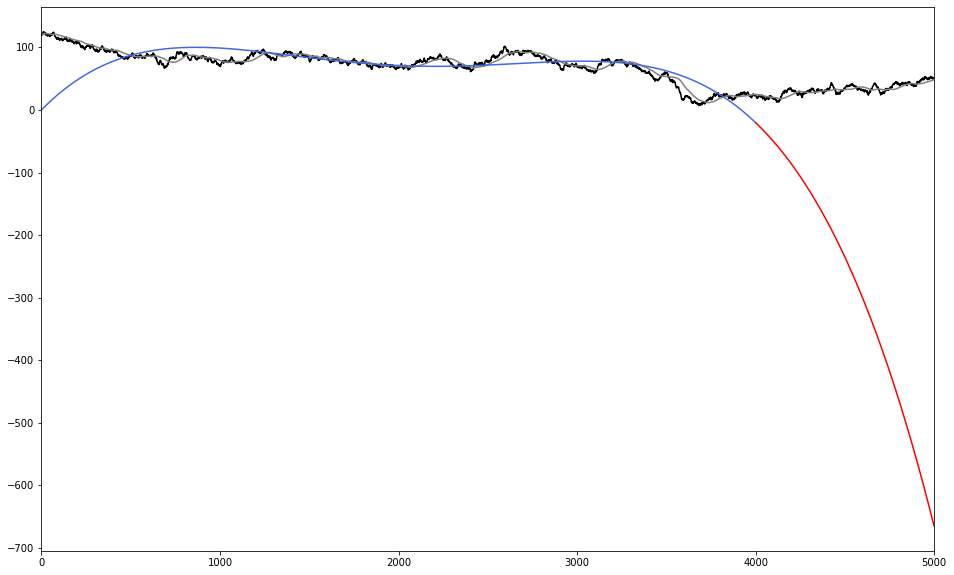

In [8]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)

t = np.arange(len(S))
avg = moving_average(S, 100)

# use the first 80 percent, to predict the last 20 percent.
data_len = 4000
fit_len = 1000

# Fit on the moving average
p, fit_p = poly_fit(data_len, t, avg[:,0], data_len, fit_len)

ax.plot(t, S, c='black')
ax.plot(t, avg[:,0], c='grey')

ax.plot(p[0:data_len], fit_p[0:data_len], c='royalblue')
ax.plot(p[data_len:-1], fit_p[data_len:-1], c='red')

ax.set_xlim(0, N)

plt.show()

Kalman

In [9]:
# # Load pricing data for a security
# start = '2013-01-01'
# end = '2015-01-01'
# x = get_pricing('LMT', fields='price', start_date=start, end_date=end)

# # Construct a Kalman filter
# kf = KalmanFilter(transition_matrices = [1],
#                   observation_matrices = [1],
#                   initial_state_mean = 0,
#                   initial_state_covariance = 1,
#                   observation_covariance=1,
#                   transition_covariance=.01)

# # Use the observed values of the price to get a rolling mean
# state_means, _ = kf.filter(x.values)
# state_means = pd.Series(state_means.flatten(), index=x.index)

# # Compute the rolling mean with various lookback windows
# mean30 = pd.rolling_mean(x, 30)
# mean60 = pd.rolling_mean(x, 60)
# mean90 = pd.rolling_mean(x, 90)

# # Plot original data and estimated mean
# plt.plot(state_means)
# plt.plot(x)
# plt.plot(mean30)
# plt.plot(mean60)
# plt.plot(mean90)
# plt.title('Kalman filter estimate of average')
# plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
# plt.xlabel('Day')
# plt.ylabel('Price');

### statsmodel forecast

#### SARIMAX
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

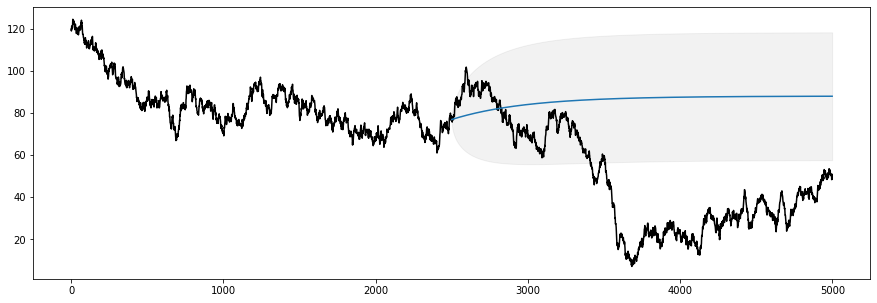

In [10]:
df_S = pd.DataFrame(S)

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(S, c='black')
mod = sm.tsa.SARIMAX(df_S[0:2500], order=(1, 0, 1), trend='c')

res = mod.fit()

# Construct the forecasts
fcast1 = res.get_forecast(steps=2500).summary_frame()
ax.plot(t[2500:5000], fcast1['mean'])
ax.fill_between(fcast1.index, fcast1['mean_ci_lower'], fcast1['mean_ci_upper'], color='k', alpha=0.05);